# **💁🏻🗨️💁🏻‍♂️대화 요약 SOLAR API code**
> **Dialogue Summarization** 경진대회에 오신 여러분 환영합니다! 🎉    
> 본 자료에서는 Solar Chat API를 이용하여 대화 요약 대회를 풀어봅니다.     

## ⚙️ 데이터 및 환경설정

### 1) 필요한 라이브러리 설치

In [ ]:
!pip install openai

In [1]:
import pandas as pd
import os
import time
from tqdm import tqdm
from rouge import Rouge # 모델의 성능을 평가하기 위한 라이브러리입니다.
from openai import OpenAI # openai==1.2.0

In [2]:
from dotenv import load_dotenv
from hydra import initialize, compose
import wandb

load_dotenv()
UPSTAGE_API_KEY = os.getenv("UPSTAGE_API_KEY")
# Jupyter 환경에서 실행
initialize(version_base="1.3", config_path="../config", job_name="test_app")  # config_path 지정
cfg = compose(config_name="config")  # config 파일 이름 지정
print(cfg)
os.chdir("../")
runtime_cwd = os.getcwd()  # 현재 작업 디렉터리 가져오기
print(f"runtime_cwd: {runtime_cwd}")
cfg.general.data_path = runtime_cwd + "/data"
cfg.general.model_cache_dir = runtime_cwd + "/models"
cfg.general.output_path = runtime_cwd + "/outputs"

{'prompt_templates': {'1': {'system': 'You are a Korean dialogue summarizer. Follow these rules:\n1. Summarize the dialogue in Korean only\n2. Keep the summary concise and simple\n3. Do not include any English text\n4. Focus on the key points only\n', 'few_shot': '다음 지시사항에 따라 대화를 요약하세요:\n1. 한국어로만 요약하세요\n2. 간단명료하게 작성하세요\n3. 핵심 내용만 포함하세요\n\nSample Dialogue:\n{sample_dialogue}\n\nSample Summary:\n{sample_summary}\n\nDialogue:\n{dialogue}\n\nSummary:\n', 'zero_shot': 'Summarize the following dialogue:\nDialogue: {dialogue}\nSummary:\n'}, '2': {'system': 'You are a Korean dialogue summarizer. Provide a concise summary in Korean only.\nRules:\n1. Only output the summary, nothing else\n2. Do not include any instructions or markers\n3. Keep it simple and focused\n', 'instruction': 'Please summarize the following dialogue in Korean.\nBe concise and focus on the key points.\n', 'few_shot': {'user': 'Dialogue:\n{sample_dialogue}\nSummary:\n', 'assistant': '{sample_summary}', 'final_user': 'Dialog

In [3]:

print(f"cfg.keys(): {cfg.keys()}")

# wandb.init(project=cfg.general.wandb.project, entity=cfg.general.wandb.entity, name=cfg.general.timestamp)

# wandb.log({"notebook test": 1})

# wandb.finish()


cfg.keys(): dict_keys(['prompt_templates', 'general', 'prompt', 'inference', 'url', 'metrics', 'huggingface', 'lora', 'custom_config', 'model', 'train'])


### 2) Solar Chat API Client 생성하기
- 앞으로 Solar Chat API를 사용하기 위해 Client를 생성합니다.

In [4]:
#UPSTAGE_API_KEY = "up_*****************************" # upstage.ai에서 발급받은 API KEY를 입력해주세요.

client = OpenAI(
    api_key=UPSTAGE_API_KEY,
    base_url="https://api.upstage.ai/v1/solar"
)

### 4) 데이터 불러오기
- 실험에서 쓰일 데이터를 load합니다.

In [5]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import matplotlib.font_manager as fm
from konlpy.tag import Okt
# !sudo apt update
# !sudo apt install -y fonts-nanum
import re

# 설치된 폰트 목록 출력
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "Gothic" in font or "Nanum" in font:  # 원하는 키워드 필터링
        print(font)

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

def data_load(cfg):
# 데이터 경로를 지정해줍니다.
    DATA_PATH = cfg.general.data_path
    RESULT_PATH = cfg.general.output_path

    # train data의 구조와 내용을 확인합니다.
    train_df = pd.read_csv(os.path.join(DATA_PATH,'train.csv'))
    val_df = pd.read_csv(os.path.join(DATA_PATH,'dev.csv'))
    test_df = pd.read_csv(os.path.join(DATA_PATH,'test.csv'))
    return train_df, val_df, test_df


def text_replace(df, dict_replace):  
    # 데이터에서 특정 텍스트로 되어있는 부분이 있는지 확인하는 방법 : find 함수 사용
    print(f"========== {dict_replace.keys()} 포함된 데이터 확인 ==========")
    for key, value in dict_replace.items():
        
        val = df[df['dialogue'].apply(lambda x:x.find(key)!= -1)].values
        print(f"{key} 가 포함되어있는 데이터 확인 - 총 {len(val)} 개")
        print(val)
        if len(val) > 0:
            print(f"========== {key} 가 포함된 데이터 대체 시작 ==========")
            df['dialogue'] = df['dialogue'].apply(lambda x:x.replace(key, value))
            print(f"========== {key} 가 포함된 데이터 대체 완료 ==========")
            val = df[df['dialogue'].apply(lambda x:x.find(key)!= -1)].values
            print(f"{key} 가 포함되어있는 데이터 확인 - 총 {len(val)} 개")
            print(val)
    return df

def get_word_target(text, target, top_n=100):
    okt = Okt()
    print(f"========== {target} 타켓 추출 시작 ==========")
    if target == 'noun':
        target = okt.nouns(text)
    elif target == 'word':
        target = okt.morphs(text)
    for i,v in enumerate(target):
        if len(v)<2:
            target.pop(i)
    count = Counter(target)
    target_list = count.most_common(top_n)
    print(f"\n========== Target list:\n{target_list} \n==========")
    print(f"========== Count:\n{count} \n==========")
    return target_list

def visualize(target_list, title, font_path):
    # 워드클라우드 이미지 생성
    wc= WordCloud(
        font_path = font_path,    # 한글폰트 경로 설정
        background_color='white',                             # 배경 색깔 정하기
        colormap = 'Dark2',                                # 폰트 색깔 정하기
        width = 800,
        height = 800).generate_from_frequencies(dict(target_list))
    plt.figure(figsize=(10,10)) #이미지 사이즈 지정
    plt.suptitle("Word Cloud", fontsize=40)
    plt.title(title, fontsize=20)
    plt.imshow(wc, interpolation='lanczos') #이미지의 부드럽기 정도
    plt.axis('off') #x y 축 숫자 제거
    plt.show()  # 워드클라우드 이미지 확인
    return wc


def reg_masking(text,):
  pattern = r"#\w+#"  # ## 사이의 값을 추출하는 정규식 패턴
  masked = re.findall(pattern, text)
  return masked

def reg_person(text):
  pattern = r"#\w+\d#"  # ## 사이의 값을 추출하는 정규식 패턴 > special token 으로 tokenizer에 추가
  masked = re.findall(pattern, text)
  return masked

# 정규표현식 사용하기 
def data_reg(df):
    # 해당 데이터셋에는 개인정보가 포함되어 있었어서, 이 개인정보들을 마스킹 하여 제공합니다. 

    # ###
    # 전화번호 → #PhoneNumber#
    # 주소 → #Address#
    # 생년월일 → #DateOfBirth#
    # 여권번호 → #PassportNumber#
    # 사회보장번호 → #SSN#
    # 신용카드 번호 → #CardNumber#
    # 차량 번호 → #CarNumber#
    # 이메일 주소 → #Email
    # #### 
    # 두 개의 # 사이에 어떤 정보가 마스킹 되어있는지를 표시합니다. 

    # 이런 패턴을 가지고 있는 값들을 추출하기 위해서는 정규표현식을 사용할 수 있습니다. 
    # train_set = df['dialogue'].apply(lambda x:str(set(reg_masking(x))))
    all_tags = df['dialogue'].apply(reg_masking).explode()  # 각 문장에서 추출된 태그를 펼침
    tag_counts = Counter(all_tags)
    unique_token =set(all_tags)

    # 결과 출력
    print("중복 제거된 해시태그 목록:", unique_token )
    print("각 해시태그의 빈도수:", dict(tag_counts))

    # 각 행 별 eg_person 수 추가
    df['person_count'] = df['dialogue'].apply(lambda x: len(set(reg_person(x))))
    return df, unique_token, tag_counts
    # 결과 출력

def eda(df, idx, target):
    print(df.tail())
    # dialog 와 summary 각각의 모델 max_length 설정을 위한 길이 확인

    dialog_length = df['dialogue'].apply(lambda x:len(x))
    print("대화 길이에 대한 정보")
    print(dialog_length.describe())
    try:    
        summary_length = df['summary'].apply(lambda x:len(x))
        print("=================")
        print("요약문 길이에 대한 정보")
        print(summary_length.describe())

    except:
        print('Test data에는 summary가 없습니다.')
        summary_length = None

    visualize(get_word_target(df['dialogue'].iloc[idx], target), f'{target}', font_path)
 
# 우리, 정말과 같은 대화 주제별로 다른 단어가 아니라 일반적으로 대화에 많이 쓰는 단어들이 많이 등장하여 인사이트를 얻기가 조금 힘듭니다. 이런 경우를 방지하려고 TF-IDF(Term Frequency - Inverse Document Frequency) 라는 방법을 씁니다. 이는 어떤 단어가 특정 문서 내에서 얼마나 중요한 것인지를 나타내는 수치인데, 이 방법을 사용하게 되면 여러 문서에서 공통적으로 자주 등장하는 단어보다는 특정 문서 내에서 더 중요하게 판단되는 단어를 추

/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf
/usr/share/fonts/truetype/nanum/NanumSquareB.ttf
/usr/share/fonts/truetype/nanum/NanumGothic.ttf
/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf
/usr/share/fonts/opentype/urw-base35/URWGothic-Demi.otf
/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf
/usr/share/fonts/opentype/urw-base35/URWGothic-DemiOblique.otf
/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf
/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf
/usr/share/fonts/opentype/urw-base35/URWGothic-Book.otf
/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf
/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf
/usr/share/fonts/opentype/urw-base35/URWGothic-BookOblique.otf
/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf
/usr/share/fonts/truetype/nanum/NanumSquareR.ttf
/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf


==== Train Data ====
========== dict_keys(['ㅇㅇ', 'ㅋㅋ']) 포함된 데이터 확인 ==========
ㅇㅇ 가 포함되어있는 데이터 확인 - 총 0 개
[]
ㅋㅋ 가 포함되어있는 데이터 확인 - 총 2 개
[['train_3154'
  '#Person1#: 짐! 잘 지내? \n#Person2#: 찰리! 저게 너의 차야? 완전 못생겼네, 친구야! \n#Person1#: 멍청이가 되지마! 이건 1969년형 쉐비 임팔라야! 좀 고쳐야겠지만. 몇 달 안에 이 아기는 완전 멋질 거야! \n#Person2#: 아니야! 이걸 봐! 이게 바로 멋진 차야! \n#Person1#: 아쉽게도 운전자는 완전 바보야. 그런 차를 가질 수 있는 건 아빠가 그만큼 돈이 많아서야. \n#Person2#: 그가 이쪽으로 오고 있어, 차분하게 있어. \n#Person3#: 여러분! 내 차 어때요? 완전 멋지지 않아요? \n#Person1#: 맞아! 여자들이 너를 그 차로 돌아다니는 걸 보면 너에게 줄을 서게 될 거야. \n#Person3#: 정말 그럴까요? \n#Person2#: 확실해! \n#Person3#: 대박! \n#Person1#: 속았어! ㅋㅋ.. 완전 속았어. \n#Person3#: 넌 진짜 나쁜 놈이야, 찰리. 프롬 퀸과 재미있는 시간을 보낼 때, 마지막 웃음은 누가 낼지 봐. \n#Person2#: 친구야, 화내지 마! '
  '짐은 찰리의 차가 못생겼다고 생각하지만 찰리는 그저 좀 고쳐야 한다고 말한다. 그런 다음 그들은 멋진 차를 가진 #Person3#를 만난다.'
  '\n자동차']
 ['train_5429'
  '#Person1#: 너 남자친구 있어?\n#Person2#: 응, 전에 남자친구 있었어.\n#Person1#: 왜 전 남자친구야?\n#Person2#: 우리 지난달에 헤어졌어.\n#Person1#: 새로운 남자친구 생겼어?\n#Person2#: 음, 아니. 너는?\n#Person1#: 나는 혼자야, 실제 여자친구는 없고, 너

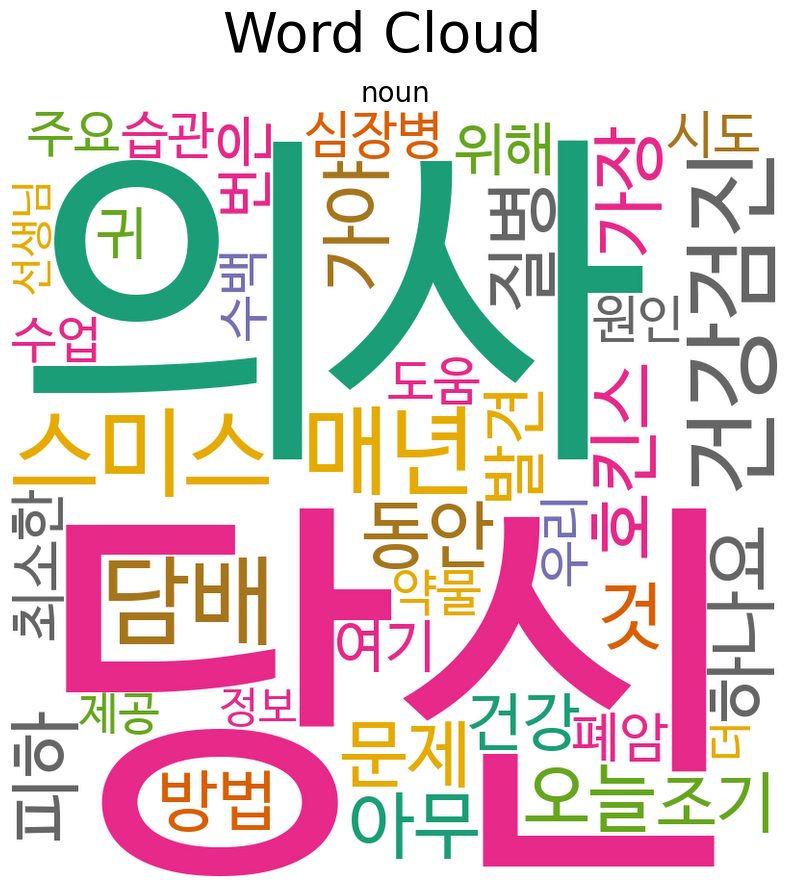

==== Val Data ====
========== dict_keys(['ㅇㅇ', 'ㅋㅋ']) 포함된 데이터 확인 ==========
ㅇㅇ 가 포함되어있는 데이터 확인 - 총 0 개
[]
ㅋㅋ 가 포함되어있는 데이터 확인 - 총 0 개
[]
중복 제거된 해시태그 목록: {'#DateOfBirth#', '#Person3#', '#Person4#', '#Address#', '#Person2#', '#PhoneNumber#', '#Person1#'}
각 해시태그의 빈도수: {'#Person1#': 2428, '#Person2#': 2242, '#PhoneNumber#': 5, '#Address#': 1, '#DateOfBirth#': 2, '#Person3#': 6, '#Person4#': 1}
       fname                                           dialogue  \
494  dev_495  #Person1#: 이제 새해가 되어서 새로운 시작을 하려고 결심했어. \r\n#P...   
495  dev_496  #Person1#: 너, 조랑 결혼했지? \r\n#Person2#: 조? 무슨 말인...   
496  dev_497  #Person1#: 무엇을 도와드릴까요, 부인?\r\n#Person2#: 몇 주 동...   
497  dev_498  #Person1#: 안녕하세요, 아마존 고객 서비스입니다. 무엇을 도와드릴까요?\n...   
498  dev_499  #Person1#: 여름이 다 되어간다는 게 믿기지 않아.\r\n#Person2#:...   

                                               summary    topic  person_count  
494  #Person1#은 새해에 금연을 하고 커밍아웃하기로 결정했습니다. #Person2...       새해             2  
495  #Person1#은 #Person2#가 조와 결혼했다고 생각했다. #Pe

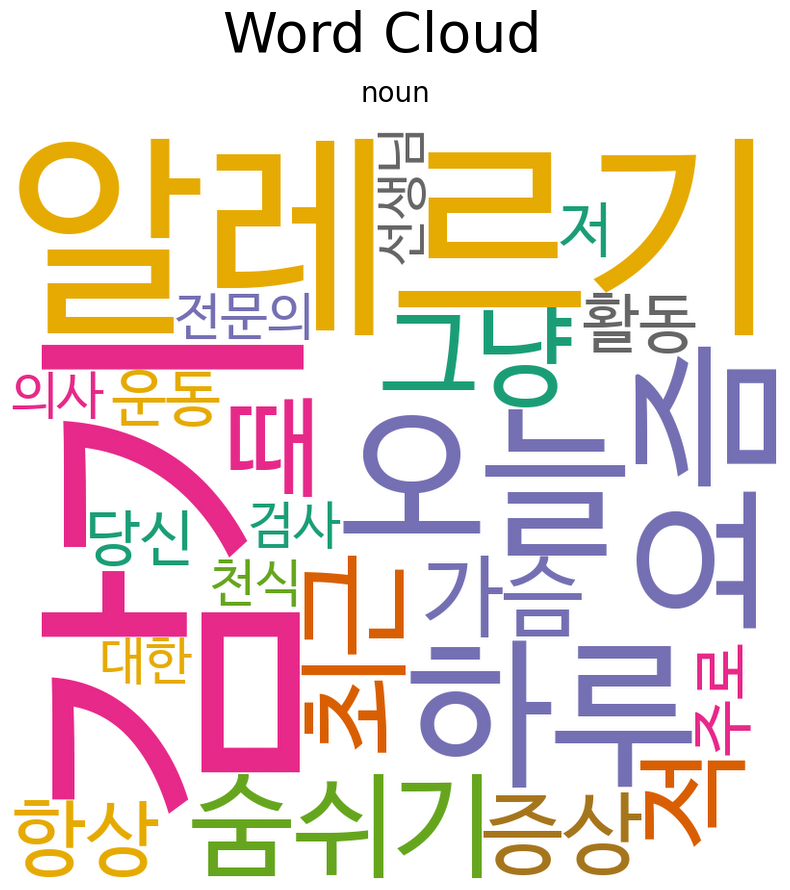

==== Test Data ====
========== dict_keys(['ㅇㅇ', 'ㅋㅋ']) 포함된 데이터 확인 ==========
ㅇㅇ 가 포함되어있는 데이터 확인 - 총 0 개
[]
ㅋㅋ 가 포함되어있는 데이터 확인 - 총 0 개
[]
중복 제거된 해시태그 목록: {'#Person3#', '#PassportNumber#', '#Address#', '#Person2#', '#PhoneNumber#', '#Person1#'}
각 해시태그의 빈도수: {'#Person1#': 2520, '#Person2#': 2308, '#PhoneNumber#': 5, '#Person3#': 15, '#Address#': 1, '#PassportNumber#': 1}
        fname                                           dialogue  person_count
494  test_495  #Person1#: 헤이, 찰리, 학교 끝나고 우리 집에 와서 나랑 비디오 게임 할...             2
495  test_496  #Person1#: 어떻게 컨트리 음악에 관심을 가지게 되었나요?\r\n#Perso...             2
496  test_497  #Person1#: 실례합니다, 앨리스. 이곳을 사용해본 적이 없는데, 기계를 어떻...             2
497  test_498  #Person1#: 매튜? 안녕!\r\n#Person2#: 스티브! 오랜만이네! 얼...             2
498  test_499  #Person1#: 헤이, 벳시, 좋은 소식 들었어?\n#Person2#: 아니, ...             2
대화 길이에 대한 정보
count     499.000000
mean      449.312625
std       239.192203
min       109.000000
25%       289.000000
50%       407.000000
75%       559.00

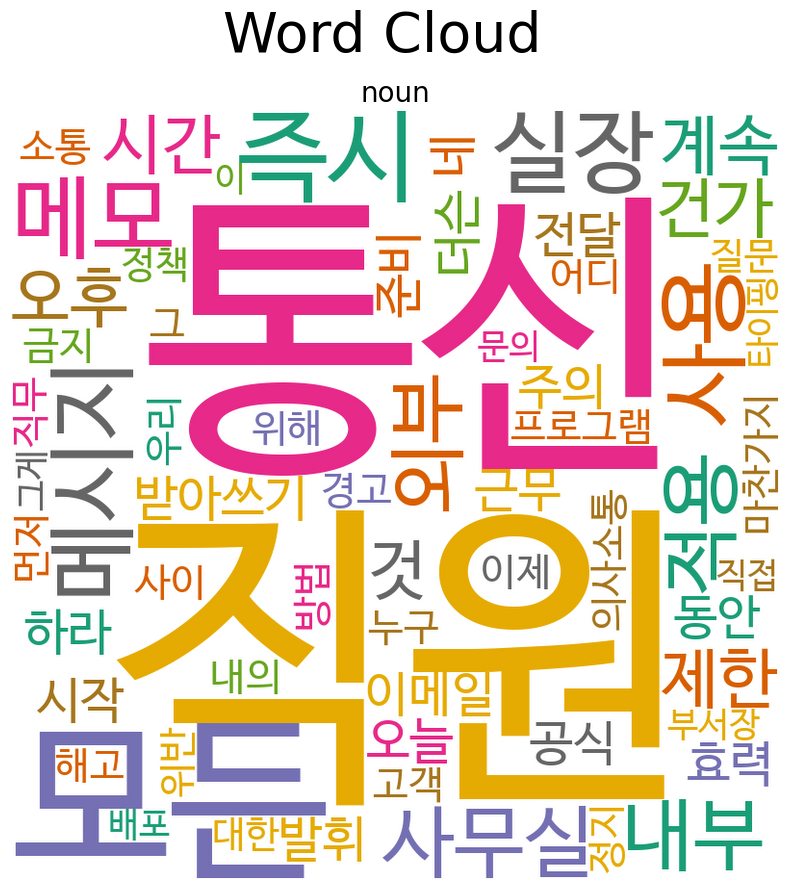

In [6]:

train_df, val_df, test_df = data_load(cfg)
### EDA
# 단어 토큰화, 명사 추출 
idx = 0
target = 'noun'
dict_replace = {'ㅇㅇ':'','ㅋㅋ':'웃기다'}
print("==== Train Data ====")
train_df = text_replace(train_df, dict_replace)
train_df, unique_token, tag_counts = data_reg(train_df)
eda(train_df, idx, target)
print("==== Val Data ====")
val_df = text_replace(val_df, dict_replace)
val_df, _, _ = data_reg(val_df)
eda(val_df, idx, target)    
print("==== Test Data ====")
test_df = text_replace(test_df, dict_replace)
test_df, _, _ = data_reg(test_df)
eda(test_df, idx, target)




In [7]:
# special token 추가
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gogamza/kobart-base-v2")
special_tokens_dict = {'additional_special_tokens': list(unique_token)}
tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.additional_special_tokens, tokenizer.additional_special_tokens_ids

/home/joon/miniconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


(['#Person#',
  '#Person7#',
  '#Person3#',
  '#DateOfBirth#',
  '#Person4#',
  '#CardNumber#',
  '#PassportNumber#',
  '#Person6#',
  '#Address#',
  '#Email#',
  '#Person2#',
  '#PhoneNumber#',
  '#Person1#',
  '#Person5#',
  '#CarNumber#',
  '#SSN#'],
 [30000,
  30001,
  30002,
  30003,
  30004,
  30005,
  30006,
  30007,
  30008,
  30009,
  30010,
  30011,
  30012,
  30013,
  30014,
  30015])

## 1. Solar Chat API 요약 성능 확인하기
- Solar Chat API을 이용하여 train 및 validation dataset에 포함된 dialogue 샘플을 요약해 봅니다.

In [8]:
# 모델 성능에 대한 평가 지표를 정의합니다. 본 대회에서는 ROUGE 점수를 통해 모델의 성능을 평가합니다.
rouge = Rouge()
def compute_metrics(pred, gold):
    results = rouge.get_scores(pred, gold, avg=True)
    result = {key: value["f"] for key, value in results.items()}
    return result

In [9]:
# Dialogue를 입력으로 받아, Solar Chat API에 보낼 Prompt를 생성하는 함수를 정의합니다.
def build_prompt(dialogue):
    system_prompt = "You are an expert in the field of dialogue summarization. Please summarize the following dialogue."

    user_prompt = f"Dialogue:\n{dialogue}\n\nSummary:\n"
    
    return [
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": user_prompt
        }
    ]

### (선택) parameter 변경하기
- Solar Chat API를 사용할 때, parameter를 변경하여, 다양한 결과를 얻을 수 있습니다.
- Parameter에 대한 자세한 설명은 [여기](https://developers.upstage.ai/docs/apis/chat#request-body)를 참고해주세요.

In [10]:
def summarization(dialogue):
    summary = client.chat.completions.create(
        model="solar-1-mini-chat",
        messages=build_prompt(dialogue),
        temperature=0.2,
        top_p=0.3,
    )

    return summary.choices[0].message.content

Train Dataset을 이용하여 요약이 잘 되는지 확인해 봅니다.

In [11]:
# Train data 중 처음 3개의 대화를 요약합니다.
def test_on_train_data(num_samples=3):
    for idx, row in train_df[:num_samples].iterrows():
        dialogue = row['dialogue']
        summary = summarization(dialogue)
        print(f"Dialogue:\n{dialogue}\n")
        print(f"Pred Summary: {summary}\n")
        print(f"Gold Summary: {row['summary']}\n")
        print("=="*50)

Validation Dataset을 이용하여 요약을 진행하고, 성능을 평가해 봅니다.

In [12]:
# Validation data의 대화를 요약하고, 점수를 측정합니다.
def validate(config, num_samples=-1):
    #num_samples = config.prompt.n_samples
    val_samples = val_df[:num_samples] if num_samples > 0 else val_df
    
    scores = []
    raw_scores = []
    predictions = []
    for idx, row in tqdm(val_samples.iterrows(), total=len(val_samples)):
        dialogue = row['dialogue']
        summary = summarization(dialogue)
        results = compute_metrics(summary, row['summary'])
        avg_score = sum(results.values()) / len(results)
        
        scores.append(avg_score)

        raw_scores.append(results)
            
        # 예측 결과 저장
        predictions.append({
            'dialogue': dialogue,
            'prediction': summary,
            'gold_summary': row['summary'],
            'rouge1_f1': results['rouge-1'],
            'rouge2_f1': results['rouge-2'],
            'rougeL_f1': results['rouge-l'],
            'avg_score': avg_score
        })
        

    # # 예측 결과를 DataFrame으로 변환하여 CSV로 저장
    # predictions_df = pd.DataFrame(predictions)
    # os.makedirs(config.general.output_path, exist_ok=True)
    # val_output_path = os.path.join(config.general.output_path, "validation_samples.csv")

    # # 텍스트 길이를 제한 (예: 1000자로 잘라서 저장)
    # predictions_df["dialogue"] = predictions_df["dialogue"].apply(lambda x: x[:1000])

    # # wandb에 결과 로깅
    # table = wandb.Table(dataframe=predictions_df)
    # wandb.log({"val_samples": table})
    # predictions_df.to_csv(val_output_path, index=False)
    
    # # wandb artifact 생성 및 로깅
    # artifact = wandb.Artifact(
    #     name="validation_results", 
    #     type="dataset",
    #     description="Validation predictions and scores"
    # )
    # artifact.add_file(val_output_path)
    # wandb.log_artifact(artifact)
        
    val_avg_score = sum(scores) / len(scores)

    print(f"Validation Average Score: {val_avg_score}")

    df = pd.DataFrame(raw_scores)
    average = df.mean().to_dict()
    print(average)
    
    return average
def log_rouge(scores):
    """ROUGE 점수를 wandb에 기록"""
    dict_rouge = {
        "rouge-1": "eval/rouge1_f1",
        "rouge-2": "eval/rouge2_f1",
        "rouge-l": "eval/rougeL_f1",
    }
    print(type(scores), scores)
    for key, value in scores.items():
        if wandb.run is not None:
            wandb.log({dict_rouge[key]: value})
        print(f"{dict_rouge[key]}: {value}")

## 2. Solar Chat API로 요약하기
- Solar Chat API을 이용하여 test dataset에 포함된 dialogue를 요약하고 제출용 파일을 생성합니다.

In [13]:
def inference(cfg):
    DATA_PATH = cfg.general.data_path
    RESULT_PATH = cfg.general.output_path
    test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))

    summary = []
    start_time = time.time()
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
        dialogue = row['dialogue']
        summary.append(summarization(dialogue))
        
        # Rate limit 방지를 위해 1분 동안 최대 100개의 요청을 보내도록 합니다.
        if (idx + 1) % 100 == 0:
            end_time = time.time()
            elapsed_time = end_time - start_time
            
            if elapsed_time < 60:
                wait_time = 60 - elapsed_time + 5
                print(f"Elapsed time: {elapsed_time:.2f} sec")
                print(f"Waiting for {wait_time} sec")
                time.sleep(wait_time)
            
            start_time = time.time()
    
    output = pd.DataFrame(
        {
            "fname": test_df['fname'],
            "summary" : summary,
        }
    )
    
    if not os.path.exists(RESULT_PATH):
        os.makedirs(RESULT_PATH)
    print(RESULT_PATH, cfg.general.timestamp)
    output.to_csv(os.path.join(RESULT_PATH, f"output_solar_{cfg.model.name}_{cfg.general.timestamp}.csv"), index=False)

    return output

In [14]:
# Dialogue를 입력으로 받아, Solar Chat API에 보낼 Prompt를 생성하는 함수를 정의합니다.
def build_prompt(dialogue):
    system_prompt = "You are an expert in the field of dialogue summarization. Please summarize the following dialogue."

    user_prompt = f"Dialogue:\n{dialogue}\n\nSummary:\n"
    
    return [
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": user_prompt
        }
    ]

In [15]:
from omegaconf import OmegaConf

config_dict = OmegaConf.to_container(cfg, resolve=True, enum_to_str=True)
print(config_dict)

{'prompt_templates': {'1': {'system': 'You are a Korean dialogue summarizer. Follow these rules:\n1. Summarize the dialogue in Korean only\n2. Keep the summary concise and simple\n3. Do not include any English text\n4. Focus on the key points only\n', 'few_shot': '다음 지시사항에 따라 대화를 요약하세요:\n1. 한국어로만 요약하세요\n2. 간단명료하게 작성하세요\n3. 핵심 내용만 포함하세요\n\nSample Dialogue:\n{sample_dialogue}\n\nSample Summary:\n{sample_summary}\n\nDialogue:\n{dialogue}\n\nSummary:\n', 'zero_shot': 'Summarize the following dialogue:\nDialogue: {dialogue}\nSummary:\n'}, '2': {'system': 'You are a Korean dialogue summarizer. Provide a concise summary in Korean only.\nRules:\n1. Only output the summary, nothing else\n2. Do not include any instructions or markers\n3. Keep it simple and focused\n', 'instruction': 'Please summarize the following dialogue in Korean.\nBe concise and focus on the key points.\n', 'few_shot': {'user': 'Dialogue:\n{sample_dialogue}\nSummary:\n', 'assistant': '{sample_summary}', 'final_user': 'Dialog

In [16]:
import random
import numpy as np
seed = 2004 #cfg.general.seed
random.seed(seed)
np.random.seed(seed)

In [17]:


model_name = "base_solar"#_fewshot_1"
run_name = cfg.general.timestamp
cfg.model.name = model_name
print(cfg.model.name)
config_dict = OmegaConf.to_container(cfg, resolve=True, enum_to_str=True)


wandb.init(config =config_dict, 
           project=cfg.general.wandb.project, 
           entity=cfg.general.wandb.entity, 
           name=run_name,
           mode="online",
           resume=False)


base_solar


wandb: Currently logged in as: nma_jungjoon (ailab_upstage_fastcampus). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [18]:

raw_scores = validate(cfg, 100) # 100개의 validation sample에 대한 요약을 수행합니다.
log_rouge(raw_scores)
wandb.finish()
    # 전체 validation data에 대한 요약을 수행하고 싶은 경우 아래와 같이 실행합니다.
    # validate() 

100%|██████████| 100/100 [02:36<00:00,  1.56s/it]

Validation Average Score: 0.11369789026932421
{'rouge-1': 0.14765699457898077, 'rouge-2': 0.04968743308871684, 'rouge-l': 0.14374924314027504}
<class 'dict'> {'rouge-1': 0.14765699457898077, 'rouge-2': 0.04968743308871684, 'rouge-l': 0.14374924314027504}
eval/rouge1_f1: 0.14765699457898077
eval/rouge2_f1: 0.04968743308871684
eval/rougeL_f1: 0.14374924314027504


eval/rouge1_f1,▁
eval/rouge2_f1,▁
eval/rougeL_f1,▁
eval/rouge1_f1,0.14766
eval/rouge2_f1,0.04969
eval/rougeL_f1,0.14375


In [25]:
wandb.finish()

In [19]:

output = inference(cfg)


  0%|          | 0/499 [00:00<?, ?it/s]

100%|██████████| 499/499 [13:47<00:00,  1.66s/it]

/home/joon/dev/nlp_task_sum/outputs 20250124_103847


## 3. Prompt Engineering
- Prompt engineering을 통해 요약 성능 향상을 시도합니다.

In [24]:
# Few-shot prompt를 생성하기 위해, train data의 일부를 사용합니다.
few_shot_samples = train_df.sample(1)

sample_dialogue1 = few_shot_samples.iloc[0]['dialogue']
sample_summary1 = few_shot_samples.iloc[0]['summary']

print(f"Sample Dialogue1:\n{sample_dialogue1}\n")
print(f"Sample Summary1: {sample_summary1}\n")

Sample Dialogue1:
#Person1#: 잘 알려져 있듯이, 짐, 나는... 나는 컴퓨터를 꽤 좋아해. 나는 컴퓨터가 아이들에게 생각하는 법을 가르친다고 생각해, 왜냐하면 그들은 논리적인 생각을 요구하거든. 
#Person2#: 하지만 나는... 나는 그것에 동의하지 않아, 왜냐하면 컴퓨터는 아이들의 생각하는 능력을 약화시키기 때문이야, 아이들은 기본적인 기술을 배우지 않거든. 
#Person1#: 무슨 말이야? 
#Person2#: 그들은 철자를 할 수 없고, 더하기를 할 수 없고, 빼기도 할 수 없어, 심지어 더 이상 기억조차 하지 않아. 그것은 그들이 가제트에 의존하기 때문이야. 
#Person1#: 그건 가제트가 아니야. 프로그램을 만드는 것은 생각을 자극하는 거야.

Sample Summary1: #Person1#은 컴퓨터가 아이들에게 생각하는 법을 가르친다고 생각하는 반면, 짐은 컴퓨터가 아이들의 생각하는 능력을 약화시킨다고 생각한다.



In [39]:
# Prompt를 생성하는 함수를 수정합니다.
def build_prompt(dialogue):
    system_prompt = "You are a expert in the field of dialogue summarization, summarize the given dialogue in a concise manner. Follow the user's instruction carefully and provide a summary that is relevant to the dialogue."

    user_prompt = (
        "Following the instructions below, summarize the given document.\n"
        "Instructions:\n"
        "1. Read the provided sample dialogue and corresponding summary.\n"
        "2. Read the dialogue carefully.\n"
        "3. Following the sample's style of summary, provide a concise summary of the given dialogue.\n\n"
        "Sample Dialogue:\n"
        f"{sample_dialogue1}\n\n"
        "Sample Summary:\n"
        f"{sample_summary1}\n\n"
        "Dialogue:\n"
        f"{dialogue}\n\n"
        "Summary:\n"
    )
    
    return [
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": user_prompt
        }
    ]

In [105]:


# model_name = "base_solar_fewshot_2"
# run_name = cfg.general.timestamp
# cfg.model.name = model_name
# print(cfg.model.name)

# wandb.init(config =config_dict, project=cfg.general.wandb.project, entity=cfg.general.wandb.entity, name=run_name)

# raw_scores = validate(cfg, 1) # 100개의 validation sample에 대한 요약을 수행합니다.
# log_rouge(raw_scores)
# wandb.finish()
#     # 전체 validation data에 대한 요약을 수행하고 싶은 경우 아래와 같이 실행합니다.
#     # validate() 

{'prompt_templates': {'1': {'system': 'You are a Korean dialogue summarizer. Follow these rules:\n1. Summarize the dialogue in Korean only\n2. Keep the summary concise and simple\n3. Do not include any English text\n4. Focus on the key points only\n', 'few_shot': '다음 지시사항에 따라 대화를 요약하세요:\n1. 한국어로만 요약하세요\n2. 간단명료하게 작성하세요\n3. 핵심 내용만 포함하세요\n\nSample Dialogue:\n{sample_dialogue}\n\nSample Summary:\n{sample_summary}\n\nDialogue:\n{dialogue}\n\nSummary:\n', 'zero_shot': 'Summarize the following dialogue:\nDialogue: {dialogue}\nSummary:\n'}, '2': {'system': 'You are a Korean dialogue summarizer. Provide a concise summary in Korean only.\nRules:\n1. Only output the summary, nothing else\n2. Do not include any instructions or markers\n3. Keep it simple and focused\n', 'instruction': 'Please summarize the following dialogue in Korean.\nBe concise and focus on the key points.\n', 'few_shot': {'user': 'Dialogue:\n{sample_dialogue}\nSummary:\n', 'assistant': '{sample_summary}', 'final_user': 'Dialog

다른 방식으로 Few-shot sample을 제공하여 Prompt를 구성해 봅니다.

In [28]:
# Few-shot sample을 다른 방식으로 사용하여 prompt를 생성합니다.
def build_prompt(dialogue):
    system_prompt = "You are a expert in the field of dialogue summarization, summarize the given dialogue in a concise manner. Follow the user's instruction carefully and provide a summary that is relevant to the dialogue."

    few_shot_user_prompt_1 = (
        "Following the instructions below, summarize the given document.\n"
        "Instructions:\n"
        "1. Read the provided sample dialogue and corresponding summary.\n"
        "2. Read the dialogue carefully.\n"
        "3. Following the sample's style of summary, provide a concise summary of the given dialogue. Be sure that the summary is simple but captures the essence of the dialogue.\n\n"
        "Dialogue:\n"
        f"{sample_dialogue1}\n\n"
        "Summary:\n"
    )
    few_shot_assistant_prompt_1 = sample_summary1
    
    user_prompt = (
        "Dialogue:\n"
        f"{dialogue}\n\n"
        "Summary:\n"
    )
    
    return [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": few_shot_user_prompt_1},
        {"role": "assistant", "content": few_shot_assistant_prompt_1},
        {"role": "user", "content": user_prompt},
    ]

### (선택) 변경된 Prompt로 test dataset에 대한 요약을 진행합니다.
- 변경된 prompt를 통해 점수가 개선되었다면, test dataset에 대한 요약을 진행하고 제출합니다.